$$ $$
  
<a id="contents"></a>

<center style ="font-size: x-large; font-weight: 600; line-height: 1.1;padding: 10px">
PyTorch Faster R-CNN for Marine Life Object Detection
</center>  
<center>
Jake Jackson, Daniel Jordan
</center>
 
### Abstract:
<div style="text-align: justify; padding: 20px"> 
Marine life object detection is an exciting young field with enormous potential to help in conservation efforts. In this study, a PyTorch faster R-CNN is experimented with on the benchmark brackish dataset. Some interesting preprocessing methods are tested that have potential that is not yet realised in this study. Canny edge detection is tested both in isolation and overlaid on top of the original image. Red channel isolation is also experimented with in hopes to minimise the blue effect that water induces through light attenuation. The best trained faster R-CNN in this study was able to infer with a mean average precision of 0.7391. This was achieved with a tuned Adam optimizer on images that were simply resized. The model can make inferences with a speed of 8.08 frames per second.
</div>

#### Key words: Neural Networks, RCNN, Computer Vision
----
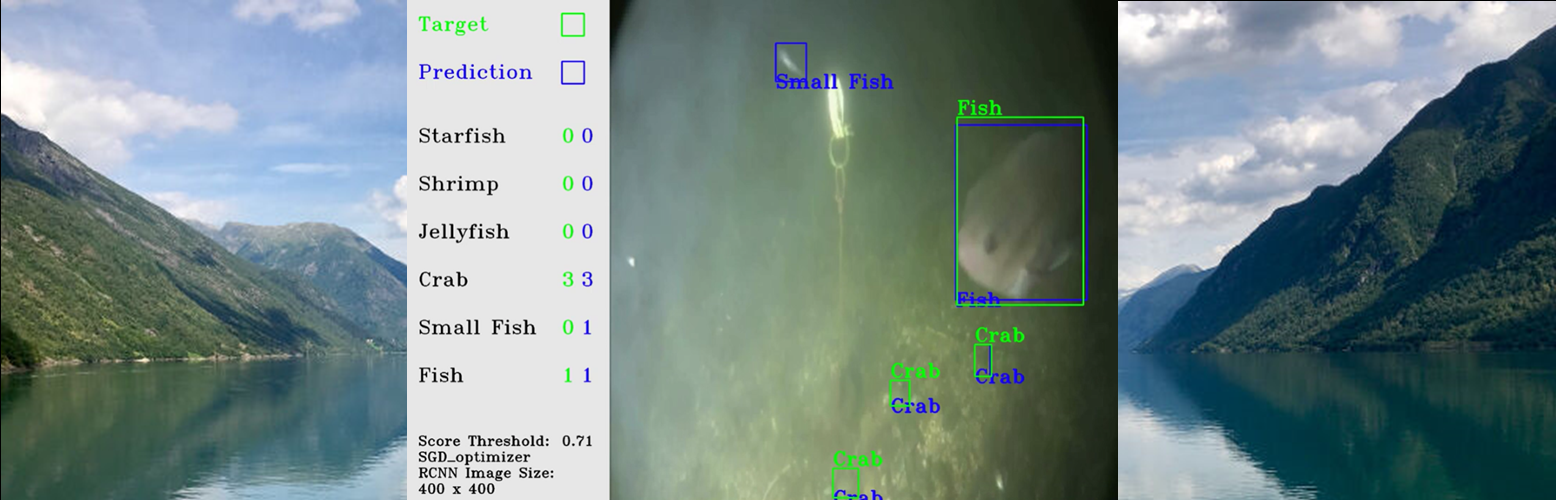
<a id="contents"></a> 
# Contents 
  * [ Section 1: Intro](#id1000)  
  * [ Section 2: Setup system](#id2000)  
      * [ 2.0.1:  Setup the system and root directories based on the machine detected](#id2010)  
  * [ Section 3: Dataset Creation ](#id3000)  
    * [ 3.1:  Importing the Brackish Pascal VOC Data](#id3100)  
    * [ 3.2:  Class Creation](#id3200)  
    * [ 3.3:  Making Datasets and Dataloaders](#id3300)  
      * [ 3.3.1:  Dataset Transforms ](#id3310)  
      * [ 3.3.2:  Checking The Transformed Images](#id3320)  
  * [ Section 4: Training ](#id4000)  
    * [ 4.1:  Train One Epoch Function](#id4100)  
    * [ 4.2:  Validation Function](#id4200)  
    * [ 4.3:  Loading and Saving Code](#id4300)  
    * [ 4.4:  Model preparation](#id4400)  
    * [ 4.5:  Optimizer Preperation](#id4500)  
    * [ 4.6:  Main Training Function](#id4600)  
    * [ 4.7:  Plotting the Losses](#id4700)  
  * [ Section 5: Performance Analysis](#id5000)  
    * [ 5.1:  Inference Function ](#id5100)  
    * [ 5.2:  Evaluation Function ](#id5200)  
    * [ 5.3:  Performing the Inference and Evaluation / Score Threshold Tuning](#id5300)  
      * [ 5.3.1:  Preprocessing Dataloaders](#id5310)  
      * [ 5.3.2:  Score Threshold Optimization](#id5320)  
      * [ 5.3.3:  Test Dataset: Computing the fps and mAP](#id5330)  
      * [ 5.3.4:  Test Dataset: Per Class mAP Plots](#id5340)  
      * [ 5.3.5:  Test Dataset: Optimizer Comparison Plots](#id5350)  
      * [ 5.3.6:  Test Dataset: Preprocessing Comparison Plots](#id5360)   
  * [ Section 6: Inference Video Creation](#id6000)  
    * [ 6.1:  Video Results: Preprocessing (Adam Optimizer)](#id6100)  
      * [ 6.1.1:  Red Transform](#id6110)  
      * [ 6.1.2:  Canny Edge Detection](#id6120)  
      * [ 6.1.3:  Canny Edge Detection With Overlay](#id6130)  
    * [ 6.2:  Video Results: Use Case(SGD: with resize transform)](#id6200)  
  * [ Section 7: Hyper Parameter Tuning](#id7000)  
      * [ 7.0.1:  Choosing an "Acceptable mAP"](#id7010)  
    * [ 7.1:  First Optuna, Speed and Learning Rate](#id7100)  
      * [ 7.1.1:  Struck Gold](#id7110)  
    * [ 7.2:  Second Optuna, Getting Importance Graph](#id7200)  
    * [ 7.3:  Third Optuna, Most Important Hyper Parameters.](#id7300)  


<a id="id1000"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
# Section 1: Intro
Underwater object detection is a relatively new field of computer vision. Large organized datasets are not currently available and few papers have been published on the topic. This study uses the underwater brackish dataset with just over 14 500 images and 6 categories. This pales in comparison to the Microsoft COCO above water dataset of 330 000 images and 80 categories. Effective implementation remains an important step for marine applications such as robot navigation and sea life monitoring. The ocean is a vast unexplored part of nature that is vital to our existence. It has absorbed roughly 30\% of human CO$_2$ emissions from the industrial revolution to the mid 1990s. This carbon capture relies on the countless species of plants and animals that exist in a delicate balance of resources. By deploying computer vision technology species populations can be estimated. This can inform government bodies of decisions on overfishing policies and installations of marine structures such as oil rigs or tidal power. This study investigates the potential of the PyTorch Faster R-CNN model to identify marine animals in images. The model will output a bounding box for each animal detected and the predicted label. The performance will be monitored in terms of the frames per second inferred (fps) and the mean average precision (mAP).

<a id="id2000"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
# Section 2: Setup system

<a id="id2010"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 2.0.1:  Setup the system and root directories based on the machine detected

In [2]:
import torch
import os
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #use gpu is available
print("Torch running on", DEVICE)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a NVIDIA GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your machine has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

WAIT= False
try:
    import google.colab
    IN_COLAB = True
    MELIKA_PC = False
    print('Running in Google Colab')
    
except:
    IN_COLAB = False
    MELIKA_PC = True

cpu_model = !sed '5!d' /proc/cpuinfo
if 'i7-8750H' in str(cpu_model): MELIKA_PC = True
        
# if AZURE but can't use since my subscription was revoked  

if IN_COLAB:
    #mount the google drive folder
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = 'drive/MyDrive/Bdata_working'
    PIN_MEM = True
    if os.cpu_count()>2:
        gpu_type = 'premium'
        BATCH_SIZE = 3*8 # increase / decrease according to GPU memeory
        NUM_WORKERS = 4 #set to 4*num_gpu
    else:
        gpu_type = 'standard'
        BATCH_SIZE = 8 # increase / decrease according to GPU memeory
        NUM_WORKERS = 2# only have 2 cores
    
    if ram_gb < 20:
      print('Not using a high-RAM runtime')
      highRAM = False
    else:
      highRAM = True
      print('You are using a high-RAM runtime!')
    tpu=False
    if tpu:
      # !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.13-cp38-cp38-linux_x86_64.whl
      # imports the torch_xla package
        import torch_xla
        import torch_xla.core.xla_model as xm
        DEVICE = xm.xla_device()
        print('running on', DEVICE)
    
if MELIKA_PC: 
    print("Notebook is running on Melika's Laptop" )
    root_dir = '/home/melika/jake/brackish_v2_960x540_voc/'# brackish
    # root_dir = '/home/melika/jake/UOT_VOC/subset_2000' #UOT_32
    highRAM =False
    WAIT = True
    gpu_type = 'NVIDIA 1060'
    BATCH_SIZE = 6 # increase / decrease according to GPU memeory
    NUM_WORKERS = 4 #set to 4*num_gpu
    PIN_MEM = True

Torch running on cuda
Fri Feb 10 21:21:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8     3W /  N/A |     13MiB /  6078MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                  

<a id="id3000"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
# Section 3: Dataset Creation 

<a id="id3100"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 3.1:  Importing the Brackish Pascal VOC Data

<a id="id3200"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 3.2:  Class Creation
These are used to create the datasets that are fed into the dataloaders.
There are two versions. One will load all data into ram. Saves about 15min per epoch in training on Azure.

In [34]:
if IN_COLAB: 
  !pip install optuna sk-video torchmetrics
  import optuna
  import skvideo.io

In [3]:
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import gc
plt.style.use('ggplot')

In [4]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, dir_path, classes, transform=None):
        self.transform = transform
        self.dir_path = dir_path
        self.classes = classes
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = cv2.imread(image_path)
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        orig_width = image.shape[1]
        orig_height = image.shape[0]
        
        # apply the image transform
        if self.transform:
            image=self.transform(image)

        new_width = image.size()[2]
        new_height = image.size()[1]

        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            #str(self.classes.index(member.find('name').text))
            #labels.append(label_to_int[str(self.classes.index(member.find('name').text))])
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)

            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/orig_width)*new_width
            xmax_final = (xmax/orig_width)*new_width
            ymin_final = (ymin/orig_height)*new_height
            ymax_final = (ymax/orig_height)*new_height
            
            ## make sure that there is no under/overspill 
            if xmin_final < 1: xmin_final = 1
            if ymin_final < 1: ymin_final = 1
            if xmax_final > new_width: xmax_final= new_width
            if ymax_final > new_height: ymax_final= new_height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
            
        num_boxes = len(boxes)
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes

        #what happends if there is no bounding box for now we will just skip
        if num_boxes==0:
          #print('no boxes')
          area = 0
        else: area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        return image, target
    
    def __len__(self):
        return len(self.all_images)

#sam but with ram load
class CustomDataset_loadRAM(Dataset):
    def __init__(self, dir_path, classes, transform=None, skip_mt=True):
        self.transform = transform
        self.dir_path = dir_path
        self.classes = classes
        self.skip_mt=skip_mt
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

        self.images_list = []
        self.targets_list = []
        self.create_var()

    def create_var(self):
        start = time.time()
        prog_bar = tqdm(self.all_images, total=len(self.all_images))        
        for id, image_name in enumerate(prog_bar):
            # capture the corresponding XML file for getting the annotations
            annot_filename = image_name[:-4] + '.xml'
            annot_file_path = os.path.join(self.dir_path, annot_filename)
            boxes = []
            labels = []
            tree = et.parse(annot_file_path)
            root = tree.getroot() 
            for member in root.findall('object'):
                labels.append(self.classes.index(member.find('name').text))
            if len(labels) == 0 and self.skip_mt == True:
              #  print('skipped')
               continue #skip images with no boxes
            # print(len(labels))

            image_path = os.path.join(self.dir_path, image_name)
            image = cv2.imread(image_path)
            # get the height and width of the image
            width = image.shape[1]
            height = image.shape[0]
            

            for member in root.findall('object'):
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)

                # make sure that there is no under/overspill 
                if xmin < 1: xmin = 1
                if ymin < 1: ymin = 1
                if xmax > width: xmax=width
                if ymax > height: ymax=height
                boxes.append([xmin, ymin, xmax, ymax])
            num_boxes = len(boxes)
            # labels to tensor
            labels = torch.as_tensor(labels, dtype=torch.int64)
            # prepare the final `target` dictionary
            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            # target["area"] = None
            # target["iscrowd"] = None
            image_id = torch.tensor([id])
            target["image_id"] = image_id
            self.images_list.append(image)
            self.targets_list.append(target)
            prog_bar.set_description(desc="Loading data into RAM")
        end = time.time()
        print('Minutes to load:',(end-start)/60)
    def __getitem__(self, idx):
        # get the image
        image = self.images_list[idx]
        target = self.targets_list[idx]
        # get the height and width of the image
        orig_width = image.shape[1]
        orig_height = image.shape[0]
        # apply the image transform
        if self.transform:
            image=self.transform(image)
        new_width = image.size[2]
        new_height = image.size[1]
        
        # box coordinates for xml files are extracted and corrected for image size given
        boxes=[]
        for box in target['boxes']:
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]

            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/orig_width)*new_width
            xmax_final = (xmax/orig_width)*new_width
            ymin_final = (ymin/orig_height)*new_height
            ymax_final = (ymax/orig_height)*new_height
            box_final = [xmin_final, ymin_final, xmax_final, ymax_final]
            boxes.append(box_final)
        num_boxes = len(boxes)
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target['boxes'] = boxes
        # area of the bounding boxes
        #what happends if there is no bounding box for now we will just skip
        if num_boxes==0:
          #print('no boxes')
          area = torch.zeros(1)
          target['boxes'] = torch.FloatTensor([[0, 0, new_width, new_height]])
        else: area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target['area'] = area
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target['iscrowed'] = iscrowd
        return image, target
    def __len__(self):
        return len(self.all_images)

<a id="id3300"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 3.3:  Making Datasets and Dataloaders

<a id="id3310"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 3.3.1:  Dataset Transforms 

These will apply our trialled preprocessing techniques just before they are inserted into the training and inference.

In [5]:
def canny_no_overlay(image, width=400,height=400):
    image = cv2.resize(image, (400,400), interpolation = cv2.INTER_AREA)
    edges=cv2.Canny(image,100,200,3)
    edges=cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)#now 3 channel

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])     

    edges = transform(edges)
    return edges

def canny_overlay(image, width=400,height=400):
    image = cv2.resize(image, (400,400), interpolation = cv2.INTER_AREA)
    edges=cv2.Canny(image,100,200,3)
    edges=cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)#now 3 channel
    image=cv2.addWeighted(image,0.5,edges,1,1)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) 
    image = transform(image)
    return image

def basic_transform(image, width=400,height=400):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((height, width))])   
    return transform(image)


def red_transform(image, width=400,height=400):
    b,g,r = cv2.split(image)
    image = cv2.resize(r, (400,400), interpolation = cv2.INTER_AREA)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),])     
    image = transform(image)
    return image

In [6]:
# Set directories for datasets
big_run=True
sub_size = 150
#run_transform=py_Transform
#run_transform=red_transform
run_transform=basic_transform
#run_transform=canny_no_overlay
#run_transform=canny_overlay

TRAIN_DIR = os.path.join(root_dir,"all_bbox","train")
VALID_DIR = os.path.join(root_dir,"all_bbox","valid")
TEST_DIR = os.path.join(root_dir,"all_bbox","test")

#Define classes to be used for the model
CLASSES= ['__background__','starfish', 'shrimp', 'jellyfish', 'crab', 'small_fish', 'fish']
NUM_CLASSES = len(CLASSES)
# highRAM=False
#if highRAM (>20Gb) then load all the images and targets into ram
if highRAM:# or not big_run:
    #make datasets
    print('Making Training Dataset')
    train_dataset = CustomDataset_loadRAM(TRAIN_DIR, CLASSES, run_transform)
    print('Making Validation Dataset')
    val_dataset = CustomDataset_loadRAM(VALID_DIR, CLASSES, run_transform)
    print('Making Test Dataset \n')
    test_dataset = CustomDataset_loadRAM(TEST_DIR, CLASSES, run_transform)
    
else:
    #make datasets
    print('Making Training Dataset')
    train_dataset = CustomDataset(TRAIN_DIR, CLASSES, run_transform)
    print('Making Validation Dataset')
    val_dataset = CustomDataset(VALID_DIR, CLASSES, run_transform)
    print('Making Test Dataset \n')
    test_dataset = CustomDataset(TEST_DIR, CLASSES, run_transform)
    
if not big_run:
    train_dataset = torch.utils.data.Subset(train_dataset, range(0,sub_size))
    val_dataset = torch.utils.data.Subset(val_dataset, range(0,sub_size))
    test_dataset = torch.utils.data.Subset(test_dataset, range(0,sub_size))

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
   
def collate_fn(batch):
    """
    To handle the data loading as different image may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))
#making the Loaders
print('\n\nbig run:',big_run)
print('high ram:',highRAM)
print('gpu_type:',gpu_type)
print('batch size', BATCH_SIZE)
print('num workers',NUM_WORKERS)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
    )
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
    )
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
    )

Making Training Dataset
Making Validation Dataset
Making Test Dataset 

Number of training samples: 9967
Number of validation samples: 1238
Number of test samples: 1239


big run: True
high ram: False
gpu_type: NVIDIA 1060
batch size 6
num workers 4


<a id="id3320"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 3.3.2:  Checking The Transformed Images

/tmp/ipykernel_3828/2584823073.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


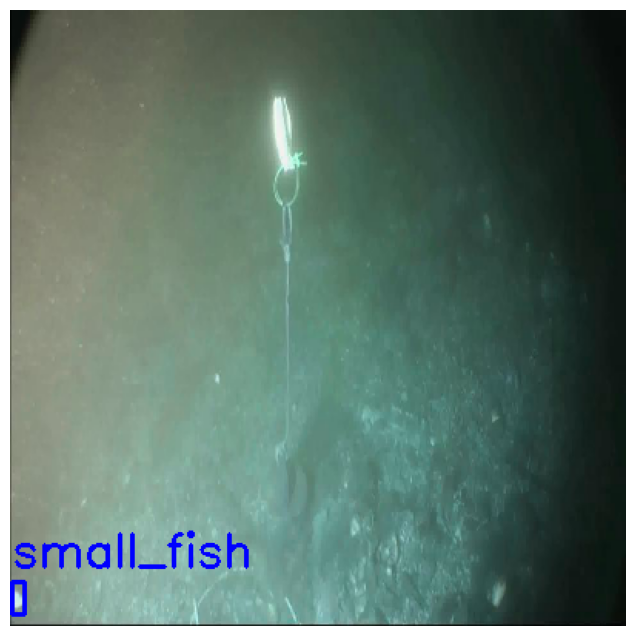

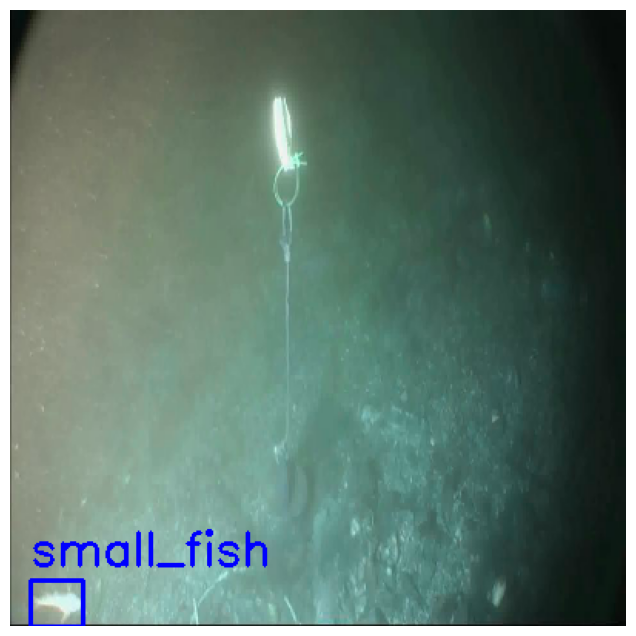

In [7]:
if IN_COLAB:
    from google.colab.patches import cv2_imshow
if MELIKA_PC:
    import matplotlib.pyplot as plt

def PIL_to_CV(image):
    return(np.array(image))

def Tensor_to_CV(image):
    transform = transforms.Compose([transforms.ToPILImage()])
    image = transform(image)
    return PIL_to_CV(image)

def show_images(data_set, num_images=3):
    for i in range(num_images):
        #get transformed image and target from dataset
        image, target = data_set[i]
        boxes = target['boxes'].numpy().astype(np.int32)
        labels = target['labels'].numpy().astype(np.int32)
        image = Tensor_to_CV(image)
        
        #image = np.transpose(image.numpy(), (1, 2, 0)).astype(np.float32)
        #image = np.ascontiguousarray(image, dtype=np.float32)
        
        #add the boxes from the targets
        for box_num, box in enumerate(boxes):
            cv2.rectangle(image,
                        (box[0], box[1]),
                        (box[2], box[3]),
                        (0, 0, 255), 2)
            cv2.putText(image, CLASSES[labels[box_num]], 
                        (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 
                        1.0, (0, 0, 255), 2)
        if IN_COLAB:
            cv2_imshow(image*255)
        else:
            plt.figure(figsize=(15, 8))
            if run_transform==red_transform:
                cmap='Reds'
            else:
                cmap=None
            plt.axis('off')
            plt.grid(b=None)
            plt.imshow(image, cmap=cmap)

show_images(val_dataset, num_images=2)

<a id="id4000"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
<a id="id4100"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 4.1:  Train One Epoch Function
## Train One Epoch Function
The train loader feeds in the batches. The for loop will loop over each batch. It computes the batch loss and its gradient then applies the optimizer to the weights. It executes minibatch gradient descent.

In [8]:
# function for running training iterations
import math

def train_one_epoch(train_data_loader, model, optimizer, trial=None, to_prune=False):
    
    print('Training')
    cut_off = 5
    batch_loss_list = []
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    for i, batch in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = batch
        images = [image.to(DEVICE) for image in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        batch_loss_list.append(loss_value)
        losses.backward()
        optimizer.step()
        if to_prune and (math.isnan(loss_value) or (i>40 and loss_value >= cut_off)): 
          print('Train Loss is:',loss_value, 'This is nan or greater than:', cut_off,'Thus the trial is ended early.')
          break
        #convergence test
        if to_prune and loss_value>0.3 and i>50 and np.nanmean(batch_loss_list[i-40:i-50]) - np.nanmean(batch_loss_list[i:i-10]) < 0.01:
          print("The train_loss is over 0.3 and in the last 40 batches the 10 batch average loss hasen't lowered by more than 0.01, thus the trial is pruned")
          break
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        del targets, images
        gc.collect()
    epoch_loss = np.mean(batch_loss_list)
    return epoch_loss


<a id="id4200"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 4.2:  Validation Function
The validation data loader will feed in the batches of images and the function will infer the targets to calculate the validation loss value. This will be used to identify the best model during training and the hyperparameter tuning.

In [9]:
# function for running validation iterations
def validate_one_epoch(valid_data_loader, model):
    print('Validating')
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    batch_loss_list = []
    for i, loss in enumerate(prog_bar):
        images, targets = loss
        images = [image.to(DEVICE) for image in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        batch_loss_list.append(loss_value)
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        del images, targets
        gc.collect()
    validation_loss = np.mean(batch_loss_list)
    return validation_loss

<a id="id4300"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 4.3:  Loading and Saving Code
This generates the file structure and sets variable names for new runs. Old runs can also be loaded in. Simply set run_name to the desired run or used the trans_to_run dictionary to set it based on the transform used.

It also contains the functions used to save various aspects of the runs.

In [8]:
# location to save model and performance data
# Please change name for each run to keep things organised
trans_to_run= {canny_overlay: 'canny_adam', canny_overlay:'img_plus_canny_adam',
              red_transform: 'red_only_adam', basic_transform:'SGD_optimizer'}

run_name=trans_to_run[run_transform]

# run_name = 'TuneTestNoWeight_decay'
#run_name = 'SGD_optimizer'
#run_name = 'red_only_adam'
# run_name = 'img_plus_canny_adam'
#run_name = 'canny_adam'
# run_name = 'TheBigRunAdam'

#autoselect corect run 

ALL_RUNS = ['TheBigRunAdam','SGD_optimizer','TuneTestNoWeight_decay','red_only_adam','img_plus_canny_adam','canny_adam']

OUT_DIR = os.path.join(root_dir,run_name)
preds_valid_dir = os.path.join(OUT_DIR,'preds','valid')
preds_train_dir = os.path.join(OUT_DIR,'preds','train')
preds_test_dir = os.path.join(OUT_DIR,'preds','test')
models_dir = os.path.join(OUT_DIR,'models')

if os.path.exists(OUT_DIR): print('***IMPORTANT***\nYour OUT_DIR -',OUT_DIR,'- exists, if you continue with training you will overwrite the run saved inside.\n\n')
!mkdir $OUT_DIR
!mkdir $OUT_DIR/preds
!mkdir $preds_valid_dir
!mkdir $preds_train_dir
!mkdir $preds_test_dir
!mkdir $models_dir

def save_model(epoch, model, optimizer, dir):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, dir)


def load_model(f_name=None,dir=None):
  model = create_model(num_classes=NUM_CLASSES)
  if f_name != None:
    best_model_dir = os.path.join(OUT_DIR, f_name)
  elif dir != None:
    best_model_dir = dir
  else: print('must give file name in out dir or a directory to another model')
  checkpoint = torch.load(best_model_dir, map_location=DEVICE)
  model.load_state_dict(checkpoint['model_state_dict'])
  return model


class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf'), to_print=False, to_save=False):
        self.best_valid_loss = best_valid_loss
        self.to_save = to_save
        self.to_print = to_print
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, trial=None):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            if self.to_print and trial == None:
              print("\n Better Model Found:")
              print(f"Best validation loss: {self.best_valid_loss}")
            if self.to_save: 
              print(f"Saving best model for epoch: {epoch}\n")
              save_model(epoch, model, optimizer, os.join.path(OUT_DIR,"best_model.pth"))
    def get_best_valid_loss(self):
        return self.best_valid_loss
#don't use pickles use torch.load(dir) and torch.save(var,dir) instead

def txt_save(var,path,name):
  text_file = open(os.path.join(path,name), "w")
  n = text_file.write(str(var))
  text_file.close()


***IMPORTANT***
Your OUT_DIR - /home/melika/jake/brackish_v2_960x540_voc/SGD_optimizer - exists, if you continue with training you will overwrite the run saved inside.


mkdir: cannot create directory ‘/home/melika/jake/brackish_v2_960x540_voc/SGD_optimizer’: File exists
mkdir: cannot create directory ‘/home/melika/jake/brackish_v2_960x540_voc/SGD_optimizer/preds’: File exists
mkdir: cannot create directory ‘/home/melika/jake/brackish_v2_960x540_voc/SGD_optimizer/preds/valid’: File exists
mkdir: cannot create directory ‘/home/melika/jake/brackish_v2_960x540_voc/SGD_optimizer/preds/train’: File exists
mkdir: cannot create directory ‘/home/melika/jake/brackish_v2_960x540_voc/SGD_optimizer/preds/test’: File exists
mkdir: cannot create directory ‘/home/melika/jake/brackish_v2_960x540_voc/SGD_optimizer/models’: File exists


<a id="id4400"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 4.4:  Model preparation

Creates the model with the MS COCO pretrained weights. It changes the number of classes of the box predictor to match what exists in the Brackish Dataset. By setting continue_training to true it will load the latest saved model and set the correct starting epoch. 

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

continue_training = False

if continue_training:
    latest_epoch_model_dir = os.path.join(models_dir,np.sort(os.listdir(models_dir))[-1])
    model = load_model(dir = latest_epoch_model_dir)
    START_EPOCH = int(latest_epoch_model_dir[-5])+1

else:
    # initialize the model and move to the computation device
    model = create_model(num_classes=NUM_CLASSES)
    START_EPOCH = 1

model = model.to(DEVICE)

<a id="id4500"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 4.5:  Optimizer Preperation

Adjust the boolean variables to select the optimizer you would like to use for the run. 

In [12]:
params = [p for p in model.parameters() if p.requires_grad]

tuned, adam, SGD = False, True, False


if tuned:
    lr = 0.00016290299565831703
    beta1 = 0.7398292562093282
    beta2 = 0.9075118063336551
    eps = 7.278808194599831e-07
    weight_decay = 0.10373865252151297
    amsgrad = True
    optimizer = torch.optim.Adam(params, lr, (beta1, beta2), eps, weight_decay, amsgrad)

if adam:  
    optimizer = torch.optim.Adam(params)

if SGD:
    params = [p for p in model.parameters() if p.requires_grad]
    #define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

<a id="id4600"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 4.6:  Main Training Function

Used to loop over the required number of epochs and run the train_one_epoch to train the weights. It also runs validate one epoch. It saves the relivant losses and models for future use. 

In [13]:
def train(model, optimizer, start_epoch=1, NUM_EPOCHS=None, loss_goal=None, MAX_EPOCHS=None, train_loader=train_loader, val_loader=val_loader, to_print=False, to_save=False, save_dir=None, loss_files=None, trial=None, only_val_last = False, to_prune=False):
    # initialize SaveBestModel class
    save_best_model = SaveBestModel(to_print=to_print,to_save=to_save)
    # start the training epochs
    train_losses = []
    val_losses = []
    cut_off=1
    def run_epoch(epoch):
        val_loss = None
        print(f"\nEPOCH {epoch} of {start_epoch+NUM_EPOCHS-1}")
        # start timer and carry out training and validation
        start1 = time.time()
        train_loss = train_one_epoch(train_loader, model, optimizer, trial=trial, to_prune=to_prune)
        end1 = time.time()
        train_losses.append(train_loss)  
        if to_print: print('Train Loss for Epoch',epoch,':',train_loss)
        if to_print: print("Took,",((end1 - start1) / 60),"minutes for training in epoch", epoch)
        if (only_val_last and epoch==NUM_EPOCHS) or not only_val_last or loss_goal != None:
        start2 = time.time()
        val_loss = validate_one_epoch(val_loader, model)
        end2 = time.time()
        if to_print: print("Took,",((end2 - start2) / 60),"minutes for validation in epoch", epoch)
        if to_print: print('Validation Loss for Epoch',epoch,':',val_loss)  
        val_losses.append(val_loss)
        save_best_model(val_loss, epoch, model, optimizer, trial=trial)
        if to_save: save_model(epoch,model,optimizer,os.path.join(save_dir,'epoch'+str(epoch)+'.pth'))
        #used to keep gpu from overheating 
        if WAIT:
            time.sleep(60*5)
        return val_loss
        
  #go for set number of epochs
  if NUM_EPOCHS != None:
    for epoch in range(start_epoch,start_epoch+NUM_EPOCHS):
        val_loss = run_epoch(epoch)    
    
  #geep going untill you reach the loss goal
    elif loss_goal != None:
        epoch = 0
        val_loss=float('inf')
        while val_loss > loss_goal:
            epoch+=1
            val_loss = run_epoch(epoch)
            if val_loss <= loss_goal:
                print('\n**Loss Goal Reached**\n')
                print('trial_num:',trial.number)
            #break if max epochs reached. prune the trial if apart of optuna trial
            if epoch == MAX_EPOCHS:
                if trial!=None:
                    raise optuna.exceptions.TrialPruned()
                break
    else: print('specify, loss_goal or NUM_EPOCHS')
    epochs_carried_out = len(val_losses)

    if to_save:
        train_losses_file = loss_files[0]
        val_losses_file = loss_files[1]
        if os.path.exists(train_losses_file):
            train_losses = torch.load(train_losses_file) + train_losses
        if os.path.exists(val_losses_file):
            val_losses = torch.load(val_losses_file) + val_losses


    # save the last model
    save_model(NUM_EPOCHS, model, optimizer, 'last_model.pth')
    # save the losses for plotting later
    torch.save(train_losses, train_losses_file)
    torch.save(val_losses, val_losses_file)
    txt_save(NUM_EPOCHS,OUT_DIR,'numEpochs:'+str(NUM_EPOCHS))
    return save_best_model.get_best_valid_loss(), epochs_carried_out


In [14]:
loss_files = (os.path.join(OUT_DIR,'train_losses.pkl'), os.path.join(OUT_DIR,'val_losses.pkl'))
to_train = False
if to_train:
    train(model, optimizer, start_epoch=START_EPOCH, NUM_EPOCHS=3, to_print=True, to_save=True, save_dir=models_dir, loss_files=loss_files) 
  

<a id="id4700"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 4.7:  Plotting the Losses

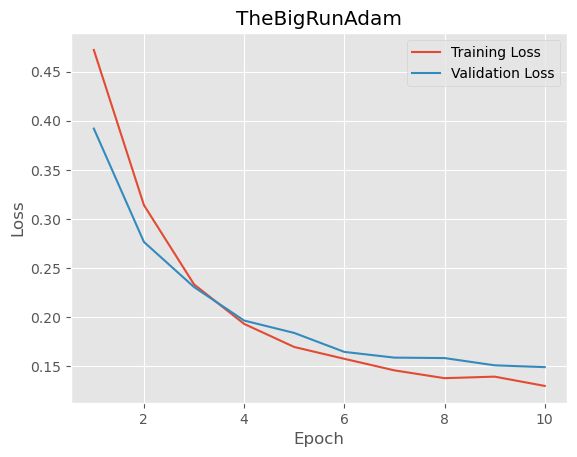

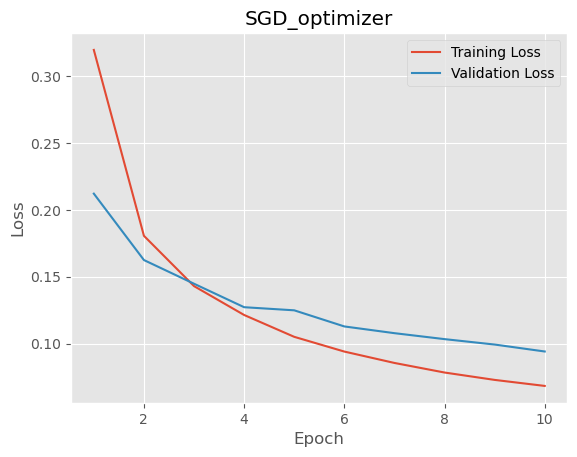

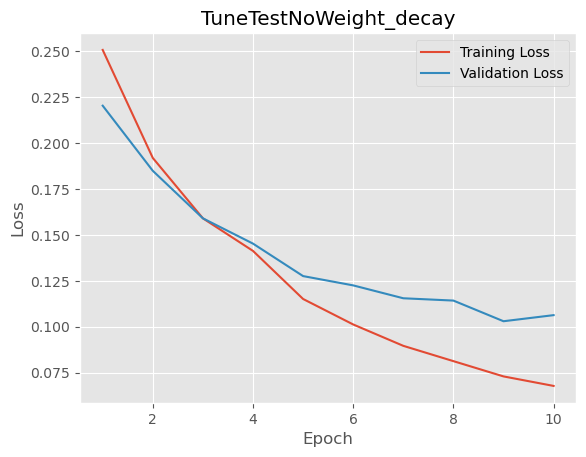

In [15]:
import matplotlib.pyplot as plt
def plot_losses(run_name):
    train_losses = torch.load(os.path.join(root_dir,run_name,'train_losses.pkl'))
    val_losses = torch.load(os.path.join(root_dir,run_name,'val_losses.pkl'))
    epochs = np.arange(1,len(train_losses)+1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.legend()
    plt.title(run_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(os.path.join(root_dir, run_name, 'Losses.png')) 
    plt.show()



plot_losses('TheBigRunAdam')
plot_losses('SGD_optimizer')
plot_losses('TuneTestNoWeight_decay')

<a id="id5000"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
<a id="id5100"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 5.1:  Inference Function 
## Inference Function 

The next function will apply to model to a provided dataloader and save the predictions to a file. It also save the targets for comparison. It returns the frames per second with which it could analyse the images.


In [16]:
if IN_COLAB: 
  !pip install torchmetrics

In [9]:
def inference(model, dataloader, save_dir):
  print('Running Inference')
  #Delete everthing in the folder to avoid issues with multiple runs
  for file_name in os.listdir(save_dir):
    # construct full file path
    file = os.path.join(save_dir,file_name)
    os.remove(file)
      
  i_start = time.time()
  prog_bar = tqdm(dataloader, total=len(dataloader))
  #"Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results."
  model.to(DEVICE).eval()
  time_taken=0
  num_images=0
  for i, batch in enumerate(prog_bar):
    with torch.no_grad(): #without this pytorch tracks the gradients and the GPU memory explodes during evaluation
      images, targets = batch
      targets_cpu = targets
      # convert images to tensor and send to the GPU
      images = [image.to(DEVICE) for image in images]
      #Sends the tensors in the target dict to the device
      targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
      # Gets the predictions for all images in the batch
      t_start = time.time()
      preds = model(images)
      t_end = time.time()
      time_taken += t_end-t_start
      num_images += len(images)
      
      #move predictions to cpu so there are no errors when loading later.
      # preds = [{k: v.to('cpu') for k, v in p.items()} for p in preds]
      
      #saving all the predictions as pickles, one pickle per image. it has the target id as the file name
      for p, t in zip(preds, targets_cpu):
        torch.save((p,t), os.path.join(save_dir,str(t['image_id'].numpy())+'.pkl'))
      # do some garbage collection to save memory on gpu
      del preds; del targets; del images
      gc.collect()
  fps = num_images/time_taken
  i_end = time.time()
  print('Inference took',(i_end-i_start)/60,'minutes to complete')
  return fps


<a id="id5200"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 5.2:  Evaluation Function 

The next function will load the previously saved predictions and use them to calculate the mAP (mean average precision). This is a measure of how accurate the model is at finding objects and labeling them correctly.  It will calculate a mAP for various score thresholds given. The score is a number from 0 to 1 which encapsulates how certain the algorithem is that there is an object in a guessed box. We can remove boxes that fall below a threshold.

In [43]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import gc

def evaluation(load_dir, score_thresholds):
  print('\nCalculating the Mean Average Precision')
  all_files_read = False
  targets = []
  preds_orig = []
  i=0
  while not all_files_read:
    try:
      p,t = torch.load(os.path.join(load_dir,'['+str(i)+'].pkl'),map_location=torch.device('cpu'))  
      targets.append(t)
      # p = {k:v.to('cpu') for (k,v) in p.items()}
      preds_orig.append(p)

    except FileNotFoundError as fe:
      all_files_read = True
      print(i,'Predictions were read')
      print(fe)
    except Exception as e: print(e)
    i+=1
    
  
  def apply_threshold(p,s_thresh):
    mask = p['scores']>s_thresh
    p['scores']=p['scores'][mask]
    p['boxes']=p['boxes'][mask]
    p['labels']=p['labels'][mask]
    return p

  index_error_count = 0
  def calculate_mAP(score_threshold):
    global index_error_count
    metric = MeanAveragePrecision(class_metrics=True)  
    # p is the prediction on one image, it is a dictionary with the labels, boxes and scores .etc as keys
    preds = []
    for p in preds_orig:
      try: p = apply_threshold(p,score_threshold)
      except IndexError: 
        index_error_count+=1
        continue 
      except Exception as e: print(e)
      preds.append(p)
    metric.update(preds,targets)
    mAP_dict = metric.compute()
    mAP = mAP_dict['map'].item()
    AP = mAP_dict['map_per_class']
    print(AP)
    AP = [i.item() for i in AP]
    return mAP, AP

  print('index_error_count',index_error_count)
  mAPs = []
  APs = []
  for s in score_thresholds:
    mAP, AP = calculate_mAP(s)
    mAPs.append(mAP)
    APs.append(AP)
  return mAPs, APs

          

<a id="id5300"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 5.3:  Performing the Inference and Evaluation / Score Threshold Tuning

The score threshold needs to be tuned before final performance graphs can be created. The model outputs a score for each box which is a level of certainty that the box contains an object. The best model found in training (lowest validation loss) will be used to tune this threshold. It will be used to infer the boxes in all the validation images. The score threshold is proportional to the number of boxes predicted for an image. The number of predicted boxes will be compared to the true number of boxes in the entire set. The score threshold where this difference is minimum is set as the best score threshold. This is applied to each run, being tested. The runs are:
```Python
ALL_RUNS = ['TheBigRunAdam', 'SGD_optimizer', 'TuneTestNoWeight_decay', 
            'red_only_adam', 'img_plus_canny_adam', 'canny_adam']
```

<a id="id5310"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 5.3.1:  Preprocessing Dataloaders

In [10]:

#making the datasets for the transforms tested
test_dataset_canny_overlay = CustomDataset(TEST_DIR, CLASSES, canny_overlay)
sub_size = len(test_dataset_canny_overlay)
test_dataset_canny_overlay = torch.utils.data.Subset(test_dataset_canny_overlay, range(sub_size))
print(f"Number of test samples: {len(test_dataset_canny_overlay)}")
test_loader_canny_overlay = DataLoader(test_dataset_canny_overlay,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_fn,pin_memory=True)

test_dataset_canny = CustomDataset(TEST_DIR, CLASSES, canny_no_overlay)
test_dataset_canny = torch.utils.data.Subset(test_dataset_canny, range(sub_size))
print(f"Number of test samples: {len(test_dataset_canny)}")
test_loader_canny = DataLoader(test_dataset_canny,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_fn,pin_memory=True)

test_dataset_red = CustomDataset(TEST_DIR, CLASSES, red_transform)
test_dataset_red = torch.utils.data.Subset(test_dataset_red, range(sub_size))
print(f"Number of test samples: {len(test_dataset_red)}")
test_loader_red = DataLoader(test_dataset_red,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_fn,pin_memory=True)


#making the datasets for the transforms tested
val_dataset_canny_overlay = CustomDataset(VALID_DIR, CLASSES, canny_overlay)
sub_size = len(val_dataset_canny_overlay)
val_dataset_canny_overlay = torch.utils.data.Subset(val_dataset_canny_overlay, range(sub_size))
print(f"Number of validation samples: {len(val_dataset_canny_overlay)}")
val_loader_canny_overlay = DataLoader(val_dataset_canny_overlay,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_fn,pin_memory=True)

val_dataset_canny = CustomDataset(VALID_DIR, CLASSES, canny_no_overlay)
val_dataset_canny = torch.utils.data.Subset(val_dataset_canny, range(sub_size))
print(f"Number of validation samples: {len(val_dataset_canny)}")
val_loader_canny = DataLoader(val_dataset_canny,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_fn,pin_memory=True)

val_dataset_red = CustomDataset(VALID_DIR, CLASSES, red_transform)
val_dataset_red = torch.utils.data.Subset(val_dataset_red, range(sub_size))
print(f"Number of validation samples: {len(val_dataset_red)}")
val_loader_red = DataLoader(val_dataset_red,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_fn,pin_memory=True)

ALL_RUNS = ['TheBigRunAdam','SGD_optimizer','TuneTestNoWeight_decay','red_only_adam','img_plus_canny_adam','canny_adam']
test_data_loaders = [test_loader,test_loader,test_loader,test_loader_red,test_loader_canny_overlay,test_loader_canny]
val_data_loaders = [val_loader,val_loader,val_loader,val_loader_red,val_loader_canny_overlay,val_loader_canny]

Number of test samples: 1239
Number of test samples: 1239
Number of test samples: 1239
Number of validation samples: 1238
Number of validation samples: 1238
Number of validation samples: 1238


<a id="id5320"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 5.3.2:  Score Threshold Optimization

Best epoch for SGD_optimizer is, 10
Running Inference


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [02:44<00:00,  1.26it/s]


Inference took 2.739146335919698 minutes to complete


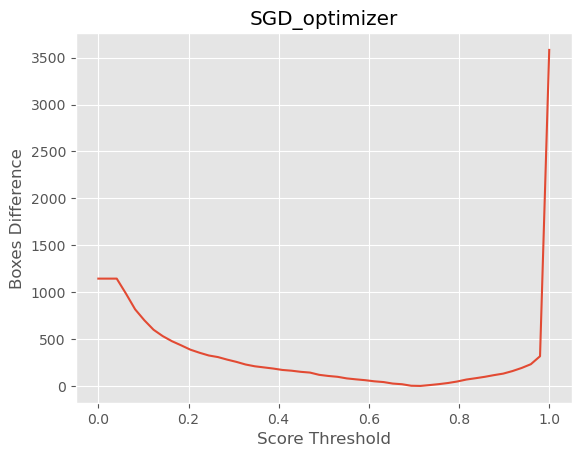

Best Score Threshold is: 0.7142857142857142


In [19]:
#running inference on the validation set for the best saved model of all epochs, to then calculate,
#the best score threshold
def best_score_threshold(run_name, data_loader):
    val_loss_min_epoch = np.argmin(torch.load(os.path.join(root_dir,run_name,'val_losses.pkl')))+1
    print('Best epoch for', run_name, 'is,', val_loss_min_epoch)
    model = load_model(dir = os.path.join(root_dir,run_name,'models','epoch'+str(val_loss_min_epoch)+'.pth'))
    preds_dir = os.path.join(root_dir,run_name,'preds','best_model_val')
    if not os.path.exists(preds_dir): os.mkdir(preds_dir)
    fps = inference(model, data_loader, preds_dir)
    
    def num_box(preds_dir, score_threshold):
        total_target_boxes = 0
        total_pred_boxes = 0
        pred_files = os.listdir(preds_dir)
        for f in pred_files:
            #get the predicted target from model 
            pred, target = torch.load(os.path.join(preds_dir,f),map_location=torch.device('cpu'))#torch.load(os.path.join(preds_dir,'['+str(i)+'].pkl'))
            #print(pred)
            labels_pred=pred['labels'].to('cpu'); scores_pred=pred['scores'].to('cpu') 
            score_mask = scores_pred.numpy() > score_threshold
            labels_pred = labels_pred[score_mask]
            total_pred_boxes += len(labels_pred)
            #print(target)
            labels = target['labels']
            total_target_boxes += len(labels)
        return total_target_boxes, total_pred_boxes

    score_thresholds=np.linspace(0,1,num=50)
    best_threshold=score_thresholds[0]
    prev_d_boxes = float('inf')
    d_boxes_list = []
    for st in score_thresholds:
        total_target,total_preds =num_box(preds_dir=preds_dir,score_threshold=st)
        d_boxes=((total_target-total_preds)**2)**0.5

        if d_boxes< prev_d_boxes:
            best_threshold=st
        #print('Score Threshold', st, 'Boxes Difference', d_boxes)
        prev_d_boxes=d_boxes
        d_boxes_list.append(d_boxes)
    
    fig_scoreThresh = plt.figure()
    plt.plot(score_thresholds, d_boxes_list)
    plt.xlabel('Score Threshold')
    plt.ylabel('Boxes Difference')
    plt.title(run_name)
    plt.show()
    print('Best Score Threshold is:',best_threshold)
    torch.save(best_threshold,os.path.join(root_dir,run_name,'best_score_threshold.pkl'))
    return best_threshold

#best_score_threshold('red_only_adam', val_loader_red)
# for run_name, data_loader in zip(ALL_RUNS,val_data_loaders):
#     bth = best_score_threshold(run_name, data_loader)
#best_score_threshold('red_only_adam', val_loader_red)
runs=['SGD_optimizer']

for run_name, data_loader in zip(runs,val_data_loaders):
     bth = best_score_threshold(run_name, data_loader)


<a id="id5330"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 5.3.3:  Test Dataset: Computing the fps and mAP

Now the best score threshold have been identified, the models can be infered over the test set. This will allow the fps and mAP to be computed. This will be done for

In [21]:
calc_performance= False

def performance(score_thresholds ,model=None, preds_dir=None, data_loader=None):

    fps = inference(model, data_loader, preds_dir)
    print('The frames per second over the validation set is:',fps)

    mAPs, APs = evaluation(preds_dir, score_thresholds)
    print('Score Thresholds Attempted,',score_thresholds)
    print('\nThe mean average percisions measured is:',mAPs)
    return fps, mAPs, APs

# mAPs, APs = eval(model, preds_dir=os.path.join(OUT_DIR,'preds','epoch9'))

#evaluating the model at the end of each epoch for the test set
def perf_epochs(run_name, data_loader, data_name):
    print('\nPerformance Check')
    OUT_DIR = os.path.join(root_dir,run_name)
    print('\n OUT_DIR',OUT_DIR)
    models_dir = os.path.join(OUT_DIR, 'models')
    print('\n models_dir', models_dir)
    score_threshold = torch.load(os.path.join(OUT_DIR,'best_score_threshold.pkl'))
    APs_list = []
    mAPs_list = []
    fps_list = []
    model_fnames = ['epoch'+str(i)+'.pth' for i in range(1,len(os.listdir(models_dir))+1)]
    epoch = 1
    for model_fname in model_fnames:
        print("Model File:",model_fname)
        dir = os.path.join(models_dir,model_fname)
        model = load_model(dir=dir)
        preds_dir = os.path.join(OUT_DIR,'preds',data_name+'_epoch'+str(epoch))
        print('preds_dir:',preds_dir)
        epoch += 1
    #   preds_epoch_dir.append(preds_dir)
        if not os.path.exists(preds_dir): os.mkdir(preds_dir)
        fps, mAPs, APs = performance(score_thresholds=[score_threshold],model=model,preds_dir=preds_dir, data_loader=data_loader)
        APs_list.append(APs)
        mAPs_list.append(mAPs)
        fps_list.append(fps)
    
    APs_dir = os.path.join(OUT_DIR,data_name+'_APs.pkl')
    #if not os.path.exists(APs_dir):
    torch.save(APs_list, APs_dir)

    mAPs_dir = os.path.join(OUT_DIR,data_name+'_mAPs.pkl')
    #if not os.path.exists(mAPs_dir):
    torch.save(mAPs_list, mAPs_dir)
    txt_save('fps='+str(np.mean(fps_list)), OUT_DIR, data_name+'_fps_final.txt')

if calc_performance:
    for run_name, data_loader in zip(ALL_RUNS,test_data_loaders):
        print('\n',run_name,'\n')
        perf_epochs(run_name, data_loader, data_name='test')

<a id="id5340"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 5.3.4:  Test Dataset: Per Class mAP Plots

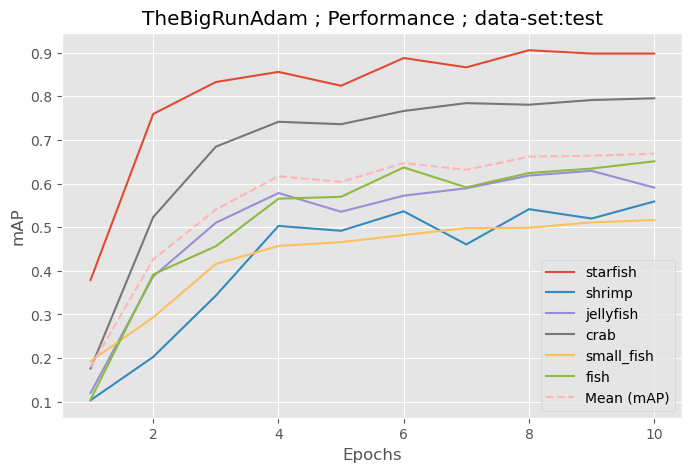

The best mAP for run ( TheBigRunAdam ) is, 0.6685068011283875 at epoch 10


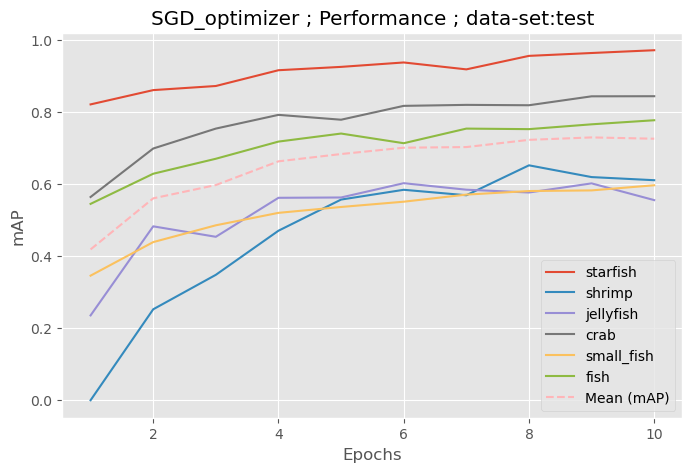

The best mAP for run ( SGD_optimizer ) is, 0.7287943363189697 at epoch 9


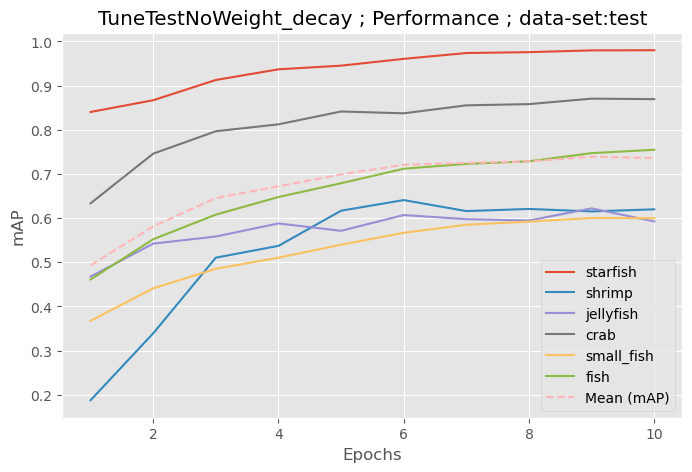

The best mAP for run ( TuneTestNoWeight_decay ) is, 0.739112377166748 at epoch 9


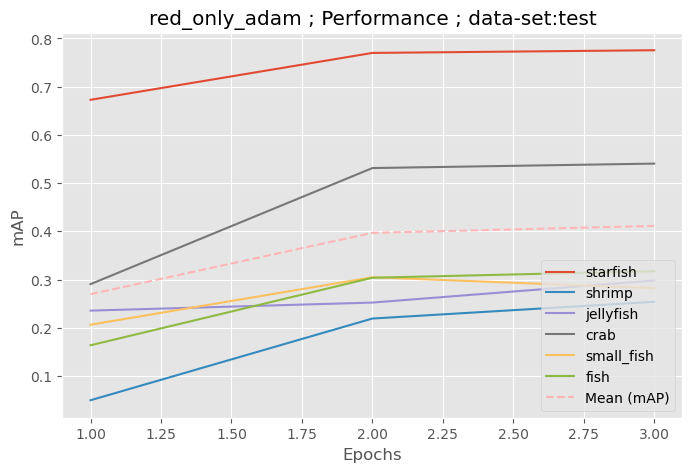

The best mAP for run ( red_only_adam ) is, 0.41125521063804626 at epoch 3


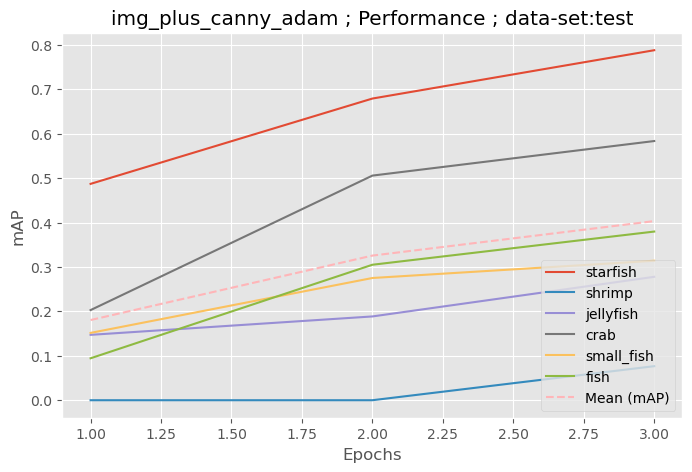

The best mAP for run ( img_plus_canny_adam ) is, 0.40321725606918335 at epoch 3


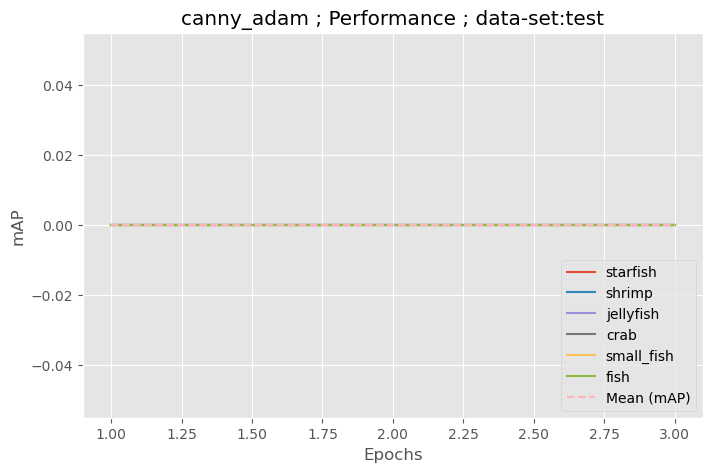

The best mAP for run ( canny_adam ) is, 0.0 at epoch 1


In [22]:
def plotAPs(run_name, data_name):
    test_APs_dir = os.path.join(root_dir, run_name,data_name+'_APs.pkl')
    test_mAPs_dir = os.path.join(root_dir, run_name,data_name+'_mAPs.pkl')
    test_APs = torch.load(test_APs_dir)
    test_mAPs = torch.load(test_mAPs_dir)
    
    test_APs_array = np.array(test_APs)[:,0,:]
    mAP_fig = plt.figure(figsize=(8,5))
    plt.plot(range(1,len(test_APs_array)+1),test_APs_array)
    plt.plot(range(1,len(test_APs_array)+1),test_mAPs,'--')
    plt.legend(CLASSES[1:]+['Mean (mAP)'],loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('mAP')
    #plt.title(run_name)
    plt.title(run_name+' ; Performance ; '+'data-set:'+data_name)
    plt.savefig(os.path.join(root_dir, run_name, 'AP_plot.png')) 
    plt.show()

    print('The best mAP for run (', run_name,') is,', np.max(test_mAPs), 'at epoch',np.argmax(test_mAPs)+1)
ALL_RUNS = ['TheBigRunAdam','SGD_optimizer','TuneTestNoWeight_decay','red_only_adam','img_plus_canny_adam','canny_adam']

for run_name in ALL_RUNS:
    plotAPs(run_name, data_name='test')

<a id="id5350"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 5.3.5:  Test Dataset: Optimizer Comparison Plots

The mAP of the three optimizers trialled will be plotted as a function of epochs.

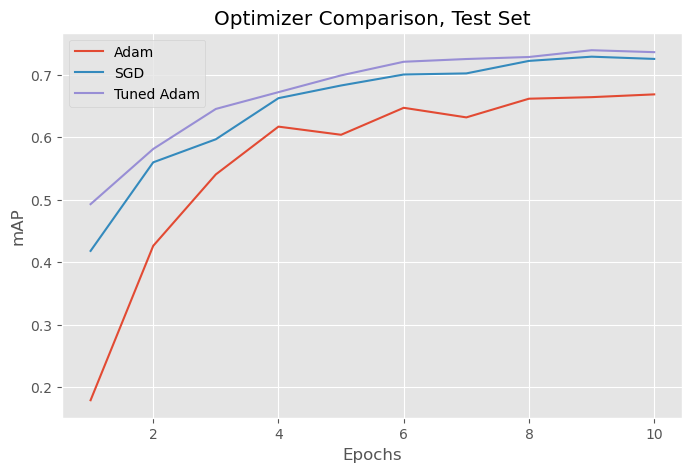

In [20]:
Adam_mAPs = torch.load(os.path.join(root_dir, 'TheBigRunAdam','test_mAPs.pkl'))
SGD_mAPs = torch.load(os.path.join(root_dir, 'SGD_optimizer','test_mAPs.pkl'))
tuned_mAPs = torch.load(os.path.join(root_dir, 'TuneTestNoWeight_decay','test_mAPs.pkl'))

mAP_fig = plt.figure(figsize=(8,5))
plt.plot(range(1,len(Adam_mAPs)+1),Adam_mAPs)
plt.plot(range(1,len(SGD_mAPs)+1),SGD_mAPs)
plt.plot(range(1,len(tuned_mAPs)+1),tuned_mAPs)
plt.legend(['Adam','SGD','Tuned Adam'])
plt.xlabel('Epochs')
plt.ylabel('mAP')
title='Optimizer Comparison, Test Set'
plt.title(title)
plt.savefig(os.path.join(root_dir, title+'.png')) 
plt.show()

<a id="id5360"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 5.3.6:  Test Dataset: Preprocessing Comparison Plots
The mAP of the three pre-processing options trialled is plotted as a function of epochs.

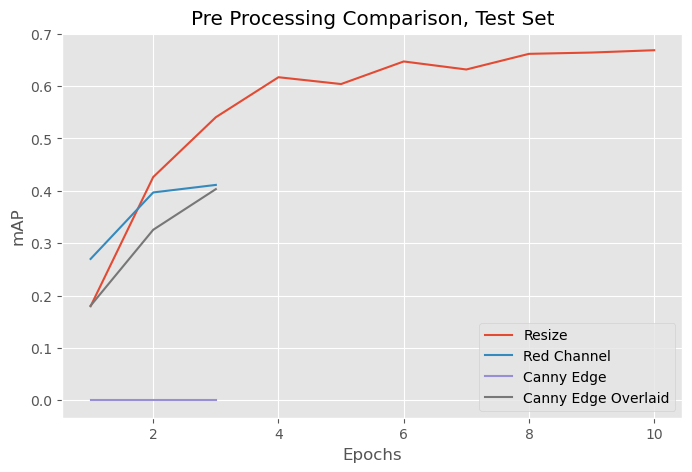

In [18]:
Adam_mAPs = torch.load(os.path.join(root_dir, 'TheBigRunAdam','test_mAPs.pkl'))
red_only_mAPs = torch.load(os.path.join(root_dir, 'red_only_adam','test_mAPs.pkl'))
canny_mAPs = torch.load(os.path.join(root_dir, 'canny_adam','test_mAPs.pkl'))
img_plus_canny_mAPs = torch.load(os.path.join(root_dir, 'img_plus_canny_adam','test_mAPs.pkl'))


mAP_fig = plt.figure(figsize=(8,5))
plt.plot(range(1,len(Adam_mAPs)+1),Adam_mAPs)
plt.plot(range(1,len(red_only_mAPs)+1),red_only_mAPs)
plt.plot(range(1,len(canny_mAPs)+1),canny_mAPs)
plt.plot(range(1,len(img_plus_canny_mAPs)+1),img_plus_canny_mAPs)
plt.legend(['Resize','Red Channel','Canny Edge','Canny Edge Overlaid'])
plt.xlabel('Epochs')
plt.ylabel('mAP')
title='Pre Processing Comparison, Test Set'
plt.title(title)
plt.savefig(os.path.join(root_dir, title+'.png')) 
plt.show()


<a id="id6000"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
# Section 6: Inference Video Creation
Used to take predictions made in inference and make a video of the results. It shows the swimming fish, target boxes and predicted boxes.

In [29]:
### Model Visualisation
if IN_COLAB: 
    from google.colab.patches import cv2_imshow
    import skvideo.io
        
def pred_vis(data_set, num_images, show=True,label=None, index=None, 
             score_threshold=0, model=None ,preds_dir=None, video_dir=None, 
             video_filename=None):
    
  # finding where label first occures in dataset
    lbl_map = {'starfish':torch.tensor(1), 'shrimp':torch.tensor(2), 'jellyfish':torch.tensor(3), 'crab':torch.tensor(4), 'small_fish':torch.tensor(5), 'fish':torch.tensor(6)}
    if index==None:
        for i in range(len(data_set)):
            _, target = data_set[i]
            if any(lbl == lbl_map[label] for lbl in list(target['labels'])):
                index=i
                break
    def write_video(images, video_dir, video_filename):
        print('write video on')
        frame_width = images[0].shape[1]
        frame_height = images[0].shape[0]
        path = os.path.join(video_dir,video_filename)
        print('path,',path)
        rate='2'

        if IN_COLAB:
            vid_out = skvideo.io.FFmpegWriter(path,outputdict={'-r': rate}, inputdict={'-r': rate})
            for im in images:
                vid_out.writeFrame(im)
            vid_out.close()
            
        if MELIKA_PC:
            vid_out = cv2.VideoWriter(path,cv2.VideoWriter_fourcc('M','J','P','G'), 2, (frame_width,frame_height))
            #vid_out = cv2.VideoWriter(path,cv2.VideoWriter_fourcc(*'MP4V'), 2, (frame_width,frame_height))
            
            for im in images:
                vid_out.write(np.uint8(im))
            vid_out.release()
            print("video saved at :", path)
                            
    
    def display_info(img,boxes_pred,labels_pred,boxes,labels,show, score_threshold,target_freq=False,pred_freq=False, scale=1):
        disp_lbls= {'__background__':'__background__','starfish':'Starfish', 'shrimp':'Shrimp', 
                    'jellyfish':'Jellyfish', 'crab': 'Crab', 'small_fish':'Small Fish', 'fish':'Fish'}
        
        if run_transform==red_transform:
            img=cv2.merge((img*0,img*0,img))

        img=img*255
        boxes, boxes_pred = boxes*scale, boxes_pred*scale
        pre_colour= (255, 0, 22)
        target_colour =(0,255,0)
        txt_colour=(0,0,0)
        threshold_color=(255,255,255)
        thickness=1*scale
        pos = 10*scale      
        font = cv2.FONT_HERSHEY_TRIPLEX
        
        #need to scale the lower res RCNN images to video res
        img_h,img_w  = img.shape[:2]
        img_vid_size = (int(scale*img_h), int(scale*img_w))
        pannel_size  = (img_vid_size[0],int(0.4*img_vid_size[1]), 3)
        if scale !=1:
            img  = cv2.resize(img, img_vid_size)
        
        #add the boxes on rescaled video
        
        #pred boxes on image
        for box_num, box_p in enumerate(boxes_pred):
            cv2.rectangle(img,
                          (box_p[0], box_p[1]),(box_p[2], box_p[3]),pre_colour, thickness)
            cv2.putText(img, disp_lbls[CLASSES[labels_pred[box_num]]],
                        (box_p[0], (box_p[3]+20)), font, 0.5*scale, pre_colour, thickness)
        
        #Target boxes on image
        for box_num, box in enumerate(boxes):
            cv2.rectangle(img,
                          (box[0],box[1]),(box[2], box[3]),target_colour, thickness)
            cv2.putText(img, disp_lbls[CLASSES[labels[box_num]]], 
                        (box[0], (box[1]-10)), font, 0.5*scale, target_colour, thickness)
        #Display  Pannel---------------------------------------------------------------------------
        if target_freq!=False and pred_freq!=False: #addes pannel automatically for the frequencies
            #add in a pannel to LHS
            left_pannel = np.ones(pannel_size)*230#sets light grey
            h1, w1 = left_pannel.shape[:2]
            h2, w2 = img.shape[:2]
            frame = np.ones((max(h1, h2), w1+w2,3), np.uint8)
            frame[:h1, :w1,:3] = left_pannel
            frame[:h2, w1:w1+w2,:3] = img
            img = frame
            del frame

            txt_x, txt_y = pos , 100
            d_bx=70
            box_x, box_y = txt_x+450, int(txt_y+d_bx/4)
            dx, dy = int(scale*112.5), int(scale*12.5) #spacings on pannel

            #Panel Content
            cv2.putText(img, 'Target',(txt_x, txt_y), font, 0.5*scale, target_colour, 2)
            cv2.rectangle(img, (box_x,box_y), (box_x+d_bx, box_y-d_bx), target_colour, thickness)

            txt_y+=3*dy
            box_x, box_y = txt_x+dx, int(txt_y+d_bx/4)
            cv2.putText(img, 'Prediction',(txt_x, txt_y), font, 0.5*scale, pre_colour, 2)
            cv2.rectangle(img, (box_x,box_y), (box_x+d_bx, box_y-d_bx), pre_colour, thickness)

            ## Add in the animal frequencies
            txt_y+=dy
            for key in target_freq:
                txt_y+=3*dy
                box_y = int(txt_y+d_bx/4)
                cv2.putText(img, disp_lbls[key],(txt_x, txt_y), font, 0.5*scale, txt_colour, 2)
                cv2.putText(img, str(target_freq[key]),(box_x, txt_y), font, 0.5*scale, target_colour, 2)
                cv2.putText(img, str(pred_freq[key]),(box_x+60, txt_y), font, 0.5*scale, pre_colour, 2)

            #add in system attributes
            txt_y += 4*dy
            cv2.putText(img, 'Score Threshold:',(txt_x, txt_y), font, 0.35*scale, txt_colour, 2) 
            cv2.putText(img, str(round(score_threshold,2)),(box_x, txt_y), font, 0.35*scale, txt_colour, 2)
            txt_y=txt_y+dy
            cv2.putText(img, run_name,(txt_x, txt_y), font, 0.35*scale, txt_colour, 2)
            txt_y=txt_y+dy
            cv2.putText(img, 'RCNN Image Size:',(txt_x, txt_y), font, 
                            0.35*scale, txt_colour, 2)
            txt_y=txt_y+dy
            cv2.putText(img, str(int(h2/scale))+' x ' +str(int(w2/scale)),(txt_x, txt_y), font, 
                            0.35*scale, txt_colour, 2)

        if show and IN_COLAB: cv2_imshow(img*255)
        if show and not IN_COLAB:
            plt.axis('off')
            plt.grid(visible=False)
            plt.figure(figsize=(15, 8))
            plt.imshow(img)
                
        return img
      
    if model != None:
        model.to(DEVICE).eval()
        images = []
        
        for i in range(index,index+num_images):
            #get transformed image and lableled target from dataset
            image, target = data_set[i]
            boxes = target['boxes'].numpy().astype(np.int32)
            labels = target['labels']
            #print(target)
            im = image
            image = image.to(DEVICE)
            with torch.no_grad(): #without this pytorch tracks the gradients and the GPU memory explodes during evaluation
                preds = model([image])
            score = preds[0]['scores'].to('cpu').numpy()
            score_mask = score > score_threshold
            boxes_pred = preds[0]['boxes'].to('cpu').numpy().astype(np.int32)[score_mask]
            labels_pred = preds[0]['labels'].to('cpu').numpy()[score_mask]
            im = np.transpose(im.numpy(), (1, 2, 0)).astype(np.float32)
            im = np.ascontiguousarray(im, dtype=np.float32)
            im = display_info(im,boxes_pred=boxes_pred,labels_pred=labels_pred,boxes=boxes,labels=labels, show=show, score_threshold=score_threshold)
            images.append(im)

        if video_filename != None: write_video(images, video_dir, video_filename)

    elif preds_dir != None:
        images = [] 
        threshold_results = []
        for i in range(index,index+num_images):           
            #get the predicted target from model 
            pred, _ = torch.load(os.path.join(preds_dir,'['+str(i)+'].pkl'),map_location=torch.device('cpu'))#torch.load(os.path.join(preds_dir,'['+str(i)+'].pkl'))

            boxes_pred=pred['boxes'].to('cpu'); labels_pred=pred['labels'].to('cpu'); scores_pred=pred['scores'].to('cpu') 
            score_mask = scores_pred.numpy() > score_threshold
            boxes_pred = boxes_pred.numpy().astype(np.int32)[score_mask]
            labels_pred = labels_pred[score_mask]
            #get transformed image and target from dataset
            im, target = data_set[i]
            boxes = target['boxes'].numpy().astype(np.int32)
            labels = target['labels']
            
            lb_t=[CLASSES[labels[i]] for i in range(0,len(labels))]
            target_freq = {CLASSES[i]: lb_t.count(CLASSES[i]) for i in range(len(CLASSES))if CLASSES[i] != '__background__' }

            lb_pt=[CLASSES[labels_pred[i]] for i in range(0,len(labels_pred))]
            pred_freq = {CLASSES[i]: lb_pt.count(CLASSES[i]) for i in range(len(CLASSES))if CLASSES[i] != '__background__' }
    
            #score_test = [(1/sum(target_freq.values()))*(target_freq[key]-pred_freq[key])**2 for key in target_freq]
            score_test = [(target_freq[key]-pred_freq[key])**2 for key in target_freq]
            if i ==index:
                total_target_boxes =sum(target_freq.values())
                total_pred_boxes = sum(pred_freq.values())
            else:
                total_target_boxes +=sum(target_freq.values())
                total_pred_boxes += sum(pred_freq.values())

            if total_pred_boxes>0:
                img_final_score= (1/total_pred_boxes)*sum(score_test)**0.5
            else:
                img_final_score=0
            #img_box_count = sum(target_freq.values())
            threshold_results.append(img_final_score)
            #print(score_test, img_final_score)
        
            #print('img', i, 'pred_list', lb_pt_unique, 'freq_list', list_freq_p)

            #print('/n')
            im = im.numpy()
            im = np.transpose(im, (1, 2, 0)).astype(np.float32)
            im = np.ascontiguousarray(im, dtype=np.float32)
            #im = show_boxes(im,boxes_pred=boxes_pred,labels_pred=labels_pred, boxes=boxes, labels=labels, show=show, score_threshold=score_threshold)
            im = display_info(im,boxes_pred=boxes_pred,labels_pred=labels_pred, boxes=boxes, 
                                         labels=labels, show=show, score_threshold=score_threshold,
                                         target_freq=target_freq, pred_freq=pred_freq, scale=4)
            images.append(im)
        
        final_threshold_result=[np.mean(threshold_results), total_target_boxes, total_pred_boxes]
               
    if video_filename != None: write_video(images, video_dir, video_filename)
    return final_threshold_result

score_threshold=torch.load(os.path.join(OUT_DIR,'best_score_threshold.pkl'))

preds_dir = os.path.join(OUT_DIR, 'preds', 'epoch3')
valid_images=int(len(os.listdir(VALID_DIR))/2)
pred_vis(val_dataset,show=False,label=None,index=200,num_images=400, 
         preds_dir=preds_dir,score_threshold=score_threshold,video_dir=OUT_DIR,
         video_filename=run_name+'.avi')

write video on
path, /home/melika/jake/brackish_v2_960x540_voc/img_plus_canny_adam/canny_only.avi
video saved at : /home/melika/jake/brackish_v2_960x540_voc/img_plus_canny_adam/canny_only.avi


[0.002272945473455874, 1252, 1589]

<a id="id6100"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 6.1:  Video Results: Preprocessing (Adam Optimizer) 

Since our project objective is to leverage the power of Neural Networks to help classify marine animals to show a use case in monitoring biodiversity. It was important for both visualising our results and serving as a debugging tool. 

<a id="id6110"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 6.1.1:  Red Transform

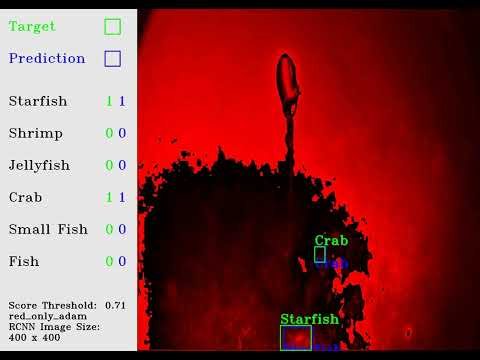

In [31]:
from IPython.display import YouTubeVideo
YouTubeVideo('XNJn_MlQBmY', width=1000, height=500)

To investigate the possiblity of the attenuation been worse for blue and green colour channels and this negatively effecting our results, we decided that the red image transform should be investigated. However, we quickly deterimined that it had a worse accuracy than the basic transform. The video above shows us that the area in the bottom left quadrant was reasonably clear in contrast with the rest of the frame which looks especially blurred. It is a reasonable assumption that this quadrent is closer and the is less light travel through the water. 

For our project having balenced score threshold was very important as an accurate frequency of occurence was a priority. The image below shows how on alow threshold the model often suggests far to many boxes. 

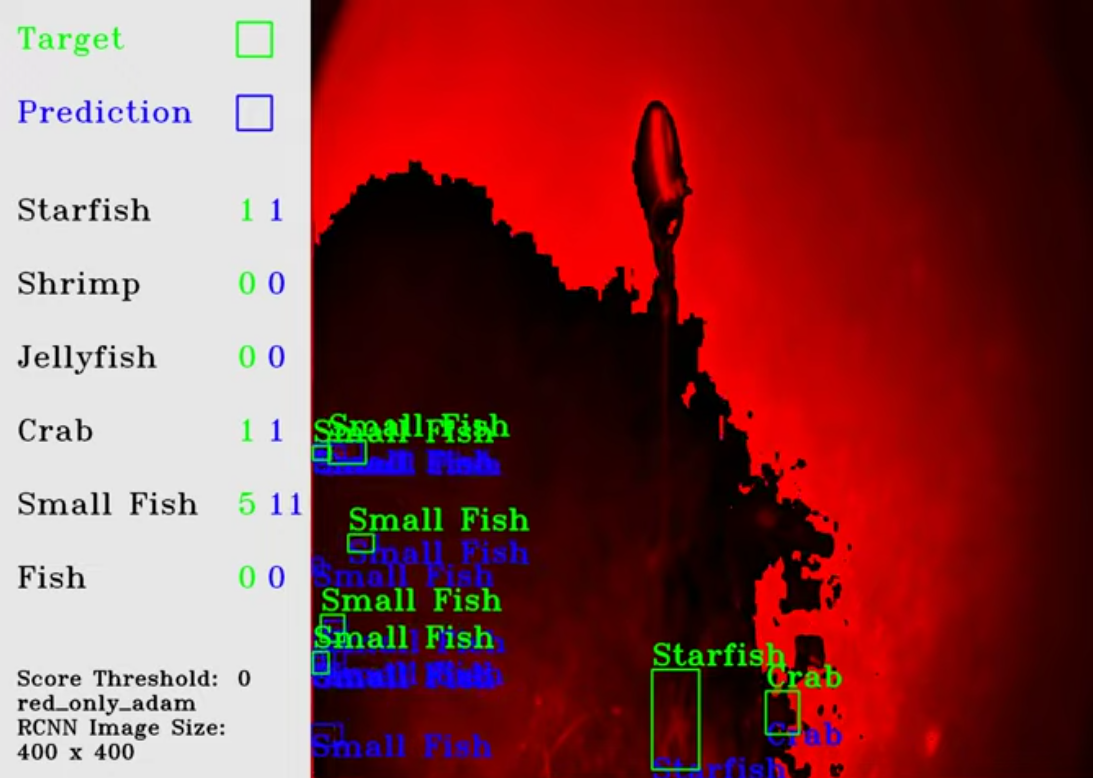

<a id="id6120"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 6.1.2:  Canny Edge Detection

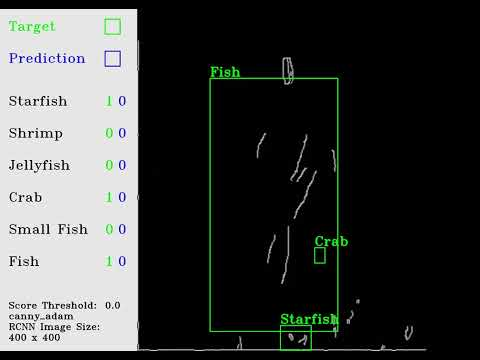

In [32]:
YouTubeVideo('k9C10xAtNI8', width=1000, height=500)

It is well known that the edges hold a significant amount of the information contained in the image. Therefore, we used a Canny Edge Detector to transform our images. Given time constraints and being in the preliminary stage of the project we selected a few images and set the Canny thresholds from that primary inspection. The video shows this was problematic and the faster R-CNN failed to produce meaningful results. Given more time it would be interesting to repeat all work involving the Canny edge detector with much lower thresholds to give the R-CNN more information to train on.  

<a id="id6130"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 6.1.3:  Canny Edge Detection With Overlay

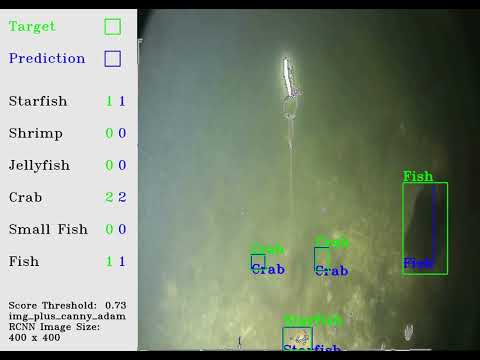

In [27]:
from IPython.display import YouTubeVideo
YouTubeVideo('07X9uzAdJmk', width=1000, height=500)

We knew that the Canny Edge detector on its own would remove all of the image information that was not detected as edges. To combat this and ensure the R-CNN, had maximum image information we added the detected edges to the resized images. Unfortunately again this was also inherited from the previous canny threshold problem so did not offer any improvement and was more computationally expensive than only resizing the images. Again in this case making the Canny thresholds more sensitive would be an exciting avenue for further research.   

<a id="id6200"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 6.2:  Video Results: Use Case (SGD: with resize transform)

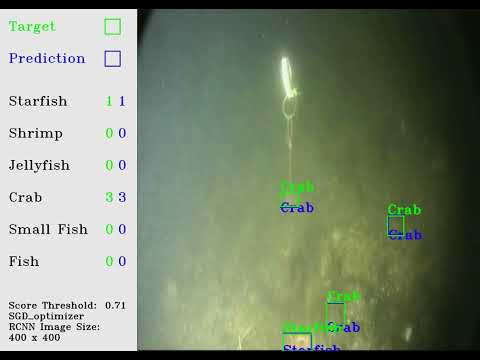

In [16]:
from IPython.display import YouTubeVideo
YouTubeVideo('EL6no_uhQ9E', width=1000, height=500)

The SGD algorithm with an optimized score threshold value of 0.71 gives gets 1417 of the 1421 total number of boxes in the 500-frame video above. The algorithms mAP on epoch 10 was 0.7288. The video shows, the results are promising.

<a id="id7000"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
# Section 7: Hyper Parameter Tuning

The main theme of this tuning is limited resources. Various decisions were made in the spirit of achieving a deep parameter search with minimal resources. 

Firstly we did not alter resNet50 architecture parameters instead we focused on the optimizer parameters. This is justified because the resNet50 a proven to perform architecture. Changing the model architecture could be further complicated by the fact that we are using reinforcement learning, with pre-trained weights from the MS COCO dataset. How would the weights of a new architecture be inferred from the pre-learned weights?

The next decision was to only ever train for the minimum number of epochs required to acquire an acceptable loss. This allows more parameters to be tested in a given time. An acceptable value for the loss was chosen based on reference values.

Three Optuna tunes will be performed in total. The first takes the default Adam optimizer and tunes the learning rate with the goal of finding the minimum number of epochs required to achieve an "acceptable loss". The second will do a scan of all the Adam parameters to generate a relative importance graph. The third will take the top 2 most important parameters and tune them on a deeper level. The other parameters will be set to the best found in the second tune.  

<a id="id7010"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 7.0.1:  Choosing an "Acceptable mAP"
MS-COCO Data Set
https://paperswithcode.com/sota/object-detection-on-coco  
Best model: InternImage - mAP 65.4%  
            FasterRCNN  - mAP 43.9%  
  
Brackish Data Set  
https://www.mdpi.com/2072-4292/13/22/4706  
Previous Paper: YOLOv4 - mAP 92.65%  
  
Given these values, the target is to beat the YOLOv4 model with the final hyperparameters. But an acceptable mAP is going to be 50% for the hyperparameter tuning. The mAP is plotted as a function of epochs in an attempt to see what validation loss corresponds to a reasonable mAP of 50%.  

Text(0, 0.5, 'Validation mAP')

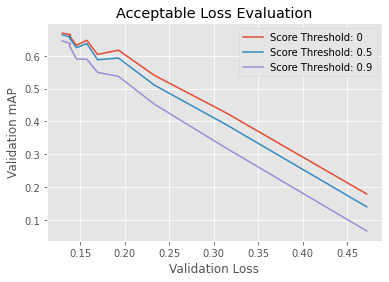

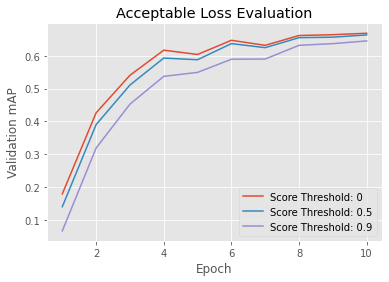

In [30]:
TheBigRunAdam = os.path.join(root_dir,'TheBigRunAdam')

val_mAPs = torch.load(os.path.join(TheBigRunAdam,'val_mAPs.pkl'))
val_losses = torch.load(os.path.join(TheBigRunAdam,'train_losses.pkl'))

fig = plt.figure()
plt.plot(val_losses,val_mAPs, label='Validation Loss')
plt.title('Acceptable Loss Evaluation')
plt.legend(['Score Threshold: 0','Score Threshold: 0.5','Score Threshold: 0.9'])
plt.xlabel('Validation Loss')
plt.ylabel('Validation mAP')

fig = plt.figure()
plt.plot(range(1,11),val_mAPs, label='Validation Loss')
plt.title('Acceptable Loss Evaluation')
plt.legend(['Score Threshold: 0','Score Threshold: 0.5','Score Threshold: 0.9'])
plt.xlabel('Epoch')
plt.ylabel('Validation mAP')

The model goes above the 'acceptable mAP' of around 0.5 at 4 epochs. This will be set as the max number for our first optuna. The val_loss after 4 epochs was 0.196, so the loss goal will be set to 0.2.

<a id="id7100"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 7.1:  First Optuna, Speed and Learning Rate
Hyperparameter tuning is resource intensive. The plan is to reduce the resources required on a large tune by ending trials that take too long to reach an acceptable loss. How long is too long is what this tune aims to answer. The learning rate is known to be one of the most important hyperparameters. It will be tuned with the aim of minimizing the number of epochs to an acceptable loss. What is an acceptable loss was answered in previous cells by looking at the relationship between loss and mAP. From altering the learning rate the best number of epochs needed to reach an acceptable loss will be recorded. For the next tune this is the max number of epochs a trial has to reach an acceptable loss.

An acceptable loss was found to be 0.2 which took 3 epochs. This was discovered in the cells above with the default Adam optimizer. 

In [31]:
import torch.optim as optim

def objective(trial):
    model = create_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    # get the model parameters, only some of them should be controlled by the optimizer. The rest were pretrained on MS coco
    params = [p for p in model.parameters() if p.requires_grad]
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)    
    Adam = optim.Adam(params, lr=lr)
    #train model
    #train(model, optimizer, NUM_EPOCHS=None, loss_goal=None, MAX_EPOCHS=None, train_loader=train_loader, val_loader=val_loader, to_print=False, to_save=False, trial=None, only_val_last = False, never_val=False):
    best_valid_loss, epochs_to_goal = train(to_print=True,loss_goal=0.2, MAX_EPOCHS=4, model=model, optimizer=Adam, trial=trial, train_loader=train_loader, val_loader=val_loader)
    print(trial.params)
    return epochs_to_goal

study_name = 'epoch_lr'
epoch_lr_storage = 'sqlite:///epoch_lr.db'
# study = optuna.create_study(study_name=study_name, storage=epoch_lr_storage, direction='minimize',load_if_exists=True)
# study.optimize(objective, n_trials=4, timeout=None)

In [32]:
# df_epoch_lr = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
# torch.save(df_epoch_lr,os.path.join(OUT_DIR,'df_epoch_lr_study.pkl'))

<a id="id7110"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
### 7.1.1:  Struck Gold

In the following table, the value is the number of epochs to reach an acceptable loss(0.2)/mAP(0.5). It was achieved in 1 epoch on the first complete trial. I call this striking gold since default adam takes 4 epochs to reach this loss/mAP. In the following tunes only one epoch will be given to each trial. This extremity will prioritise speed.

In [33]:
df = torch.load(os.path.join(OUT_DIR,'df_epoch_lr_study.pkl'))
df

,number,value,params_lr,state
0,0,NaN,NaN,FAIL
1,1,NaN,0.003405,FAIL
2,2,NaN,0.003432,FAIL
3,3,1.0,0.000139,COMPLETE
4,4,2.0,0.000209,COMPLETE
5,5,NaN,0.000031,FAIL
6,6,NaN,0.000457,FAIL


<a id="id7200"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 7.2:  Second Optuna, Getting Importance Graph
To reduce the time taken to tune the model it is important to prioritise some parameters over others. It is well known that learning rate is an important hyperparameter but it is less obvious whether adam beta1 is more important than adam beta2. This tune will look over all optimizer parameters for Adam. It will explore the parameter space to get an idea of what parameters are most important. The value to be minimised will be the validation loss after one Epoch. It is limited to 1 Epoch because the previous Optuna has shown it is possible to reach an acceptable val_loss < 0.2 in one epoch. This corresponds to around 50 mAP. It is possible for a trial with a large loss after one epoch to converge to a lower value than a trial that started with a low loss after one epoch. Waiting for each trial to converge is resource intensive. This is why the speed of the model is prioritised and each trial is given 1 epoch max to reach a low validation loss.

To further reduce the resources required the trials will be ended early if the training loss isn't below 5 after 40 batches. It is also ended early if the training loss converges. This is defined as when the average training loss over 10 epochs is not at least 0.01 lower than it was 40 batches prior.

Optuna recommends 100 trials but this is unreasonable with the resources available. Instead, 20 trials are carried out. The Adam with a tuned lr=1.39e-4 took only 1 epoch to reach an acceptable loss/mAP. All trials will be capped at this max number of epochs to save time. 

In [34]:
study2_name='AdamGraphValLoss'
storage2 = os.path.join('sqlite:///',OUT_DIR,study2_name+'.db')


In [35]:
import torch.optim as optim
study = optuna.create_study(study_name=study2_name, storage=storage2, direction='minimize',load_if_exists=True)

start = time.time()
def objective(trial):
    print('\n\nNew Trial Number:',trial.number)
    now = time.time()
    print('Studdy Running for:',(now-start)/(60*60),'hours')

    model = create_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    # get the model parameters, only some of them should be controlled by the optimizer. The rest were pretrained on MS coco
    params = [p for p in model.parameters() if p.requires_grad]

    # decide the optimizer.
    optimizer_name = 'Adam'#trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop"])
    
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    eps = trial.suggest_loguniform('eps',1e-10,1e-6)
    weight_decay = trial.suggest_uniform('weight_decay',0,1)
    beta1 = trial.suggest_uniform('beta1',0.7,1)
    beta2 = trial.suggest_uniform('beta2',0.7,1)
    amsgrad = trial.suggest_categorical('amsgrad',[True,False])
    optimizer = optim.Adam(params, lr=lr, betas=(beta1, beta2), eps=eps, amsgrad=amsgrad)
    #train(model, optimizer, NUM_EPOCHS=None, loss_goal=None, MAX_EPOCHS=None, train_loader=train_loader, val_loader=val_loader, to_print=False, to_save=False, trial=None, only_val_last = False, never_val=False):
    
    print('New Trial Params:\n',trial.params)
    val_loss, num_batches = train(NUM_EPOCHS=1, to_print=True, model=model, optimizer=optimizer, trial=trial, train_loader=train_loader, val_loader=val_subloader, to_prune=True)
    return val_loss

# study.optimize(objective, n_trials=5000, timeout=(60*60*2.5))
# df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
# torch.save(df,os.path.join(OUT_DIR,study_name+'.pkl'))

In [36]:
df2 = torch.load(os.path.join(OUT_DIR,study2_name+'.pkl')).sort_values(by=['value'])
best_trial_tune2 = {k: list(v.values())[0] for (k, v) in df2[df2['value']==min(df2['value'])].to_dict().items()}
best_trial_tune2

{'number': 21,
 'value': 0.18155726939439773,
 'params_amsgrad': True,
 'params_beta1': 0.7760125096941477,
 'params_beta2': 0.9075118063336551,
 'params_eps': 7.278808194599831e-07,
 'params_lr': 0.00010703864409045072,
 'params_weight_decay': 0.10373865252151297,
 'state': 'COMPLETE'}

In [ ]:
study2 = optuna.load_study(study_name=study2_name, storage=storage2)
#getting the most important parameters
fig = optuna.visualization.plot_param_importances(study2)
fig.show()

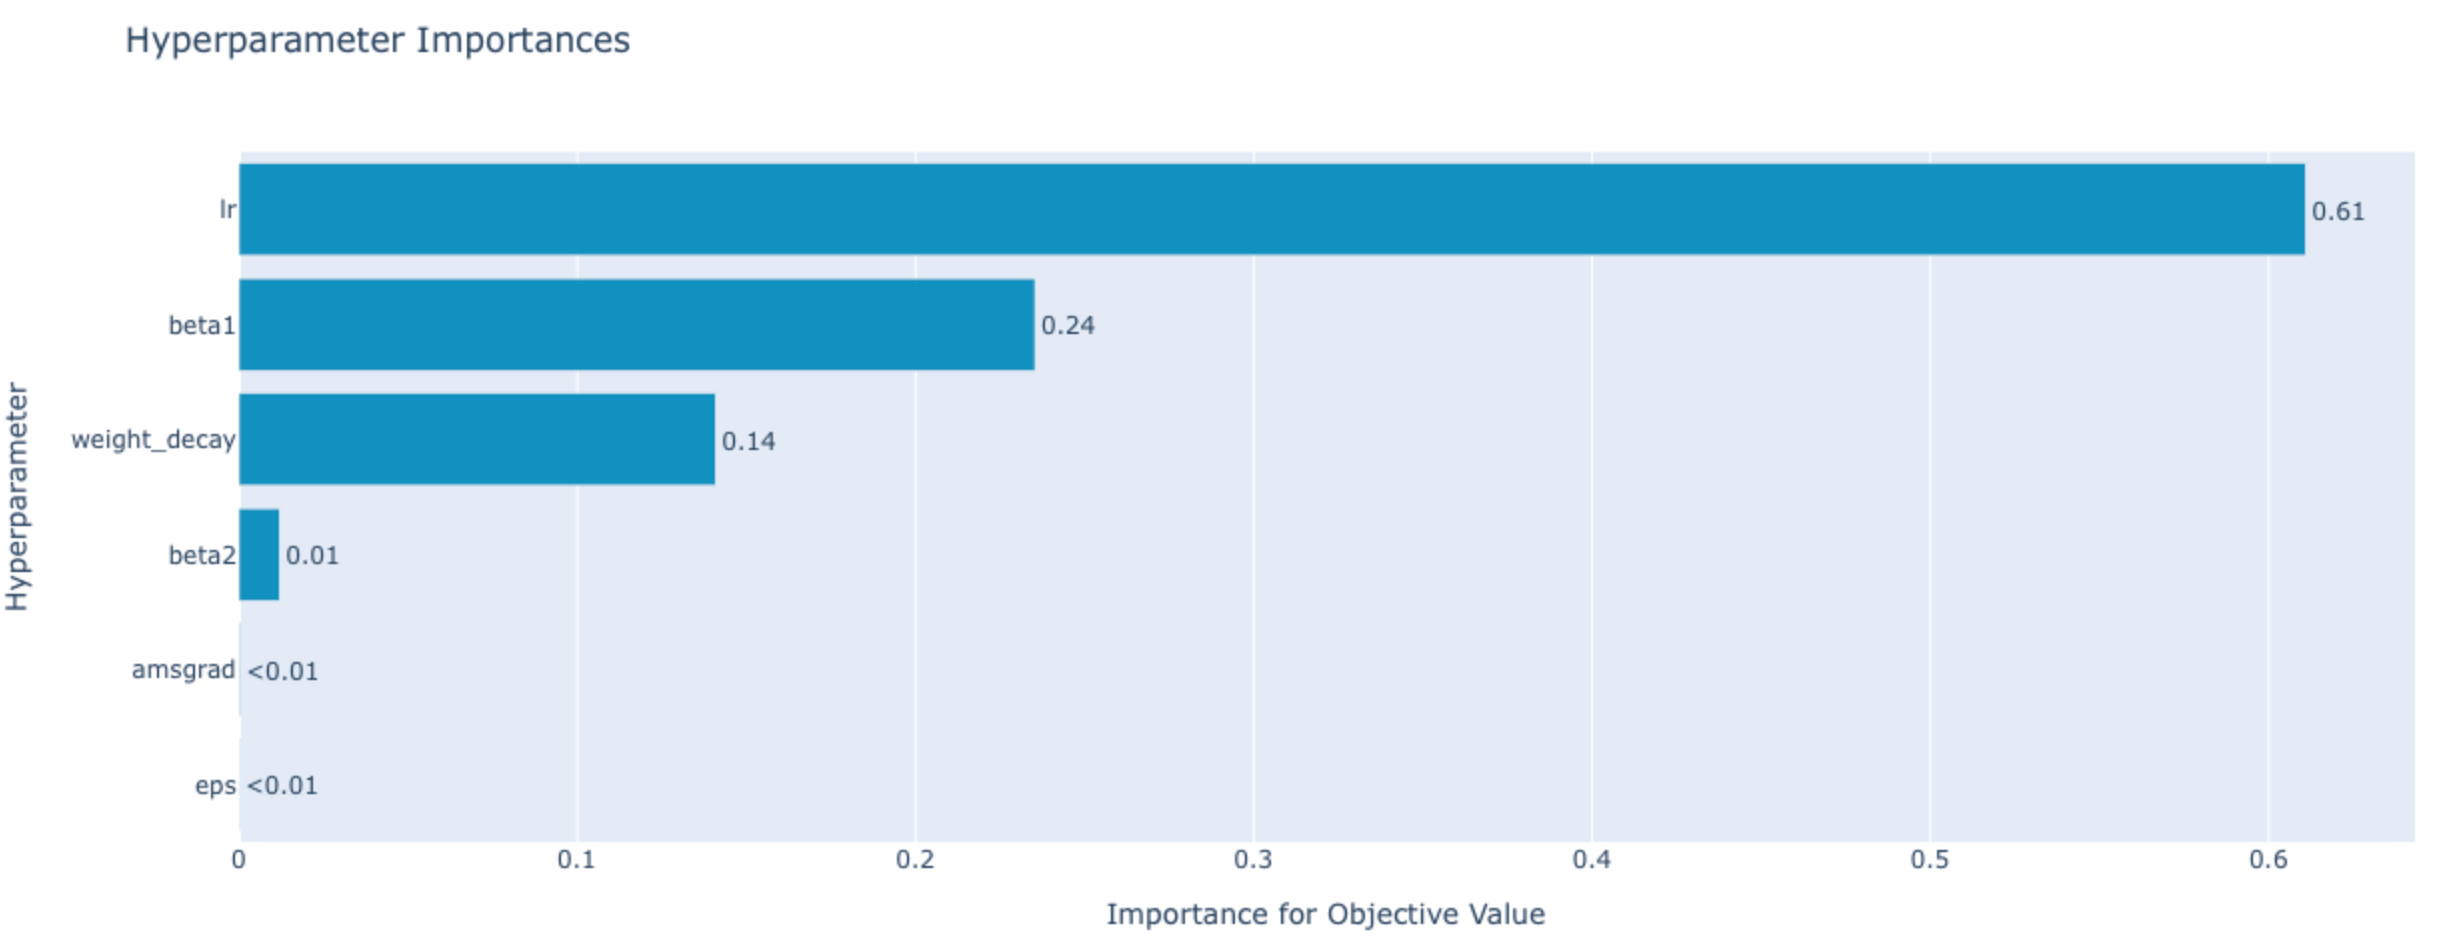

<a id="id7300"></a> 

<a href ="#contents"> 
<p style="text-align: right;">return to contents</p> 
</a> 
 
## 7.3:  Third Optuna, Most Important Hyper Parameters.

In this tune, the importance graph is used to tune deeply the top two parameters. Speed is still prioritised over accuracy and each trial will be only 1 epoch long. The small validation set is used for speed.

The trial will be ended early if the training loss is above 5 after 40 batches. Also if the training loss is greater than 0.3 and it has converged within one epoch. Convergence is defined as a loss difference of less than 0.01 over 40 batches. A mean of 10 values is taken at each end of the 40 batches to reduce the effect of loss fluctuations.  

It was ran for 20 trails

In [38]:
study3_name='thirdOtest2epochValLoss'
storage3 = os.path.join('sqlite:///',OUT_DIR,study3_name+'.db')

In [39]:
import torch.optim as optim
study = optuna.create_study(study_name=study3_name, storage=storage3, direction='minimize',load_if_exists=True)

start = time.time()
def objective(trial):
    print('\n\nNew Trial Number:',trial.number)
    now = time.time()
    print('Studdy Running for:',(now-start)/(60*60),'hours')

    model = create_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    # get the model parameters, only some of them should be controlled by the optimizer. The rest were pretrained on MS coco
    params = [p for p in model.parameters() if p.requires_grad]

    beta1 = trial.suggest_uniform('beta1',0.7,1)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer = optim.Adam(params, lr=lr, betas=(beta1, best_trial_tune2['params_beta2']), eps=best_trial_tune2['params_eps'], amsgrad=best_trial_tune2['params_amsgrad'])
    
    #train(model, optimizer, NUM_EPOCHS=None, loss_goal=None, MAX_EPOCHS=None, train_loader=train_loader, val_loader=val_loader, to_print=False, to_save=False, trial=None, only_val_last = False, never_val=False):
    
    print('New Trial Params:\n',trial.params)
    val_loss, num_epoch = train(NUM_EPOCHS=2, to_print=True, model=model, optimizer=optimizer, trial=trial, train_loader=train_loader, val_loader=val_loader, to_prune=True, only_val_last=True)
    return val_loss

# study.optimize(objective, n_trials=5000, timeout=(60*60*1))
# df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
# torch.save(df,os.path.join(OUT_DIR,study_name+'.pkl'))

[I 2023-02-04 20:51:11,454] Using an existing study with name 'thirdOtest2epochValLoss' instead of creating a new one.


In [40]:
df3 = torch.load(os.path.join(OUT_DIR,study3_name+'.pkl')).sort_values(by=['value'])
best_trial_tune3 = {k: list(v.values())[0] for (k, v) in df3[df3['value']==min(df3['value'])].to_dict().items()}
print('Best Trial', best_trial_tune3)

Best Trial {'number': 6, 'value': 0.13248292815226775, 'params_beta1': 0.7398292562093282, 'params_lr': 0.00016290299565831703, 'state': 'COMPLETE'}
